# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)
from scipy.stats import norm

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
countries = pd.read_csv("countries.csv")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.
# Criando uma cópia do dataframe original para manipulação dos dados
df = countries.copy()

In [32]:
# Exibindo quantidade de entradas e variáveis
print(f"Entradas: \t{df.shape[0]}")
print(f"Variáveis: \t{df.shape[1]}")


Entradas: 	227
Entradas: 	227


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null object
Coastline_ratio     227 non-null object
Net_migration       224 non-null object
Infant_mortality    224 non-null object
GDP                 226 non-null float64
Literacy            209 non-null object
Phones_per_1000     223 non-null object
Arable              225 non-null object
Crops               225 non-null object
Other               225 non-null object
Climate             205 non-null object
Birthrate           224 non-null object
Deathrate           223 non-null object
Agriculture         212 non-null object
Industry            211 non-null object
Service             212 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 35.5+ KB


In [8]:
# Criando um dataframe para consolidar informações que facilitem a análise dos dados
df_info = pd.DataFrame({'Colunas': df.columns,
                     'Tipo': df.dtypes,
                     ' % Missing values': round((df.isna().sum() / df.shape[0]) * 100,2),
                     'Valores Únicos' :  df.nunique()
                    })
df_info.reset_index(drop=True)



,Colunas,Tipo,% Missing values,Valores Únicos
0,Country,object,0.00,227
1,Region,object,0.00,11
2,Population,int64,0.00,227
3,Area,int64,0.00,226
4,Pop_density,object,0.00,219
5,Coastline_ratio,object,0.00,151
6,Net_migration,object,1.32,157
7,Infant_mortality,object,1.32,220
8,GDP,float64,0.44,130
9,Literacy,object,7.93,140


In [9]:
# Criando lista com as váriaveis numéricas do tipo float
variaveis_numericas_float = list(df.columns.drop(['Country','Region','Population','Area']))


In [10]:
# Substituindo ',' por '.' e convertendo as variáveis para float através de função lambda
df[variaveis_numericas_float] = df[variaveis_numericas_float].applymap(lambda x : float(str(x).replace(',','.')))


In [11]:
# Retirando os espaços vazios das variávies categóricas ('Country', 'Region') com a função str.strip()
df['Country'] = df['Country'].str.strip()
df['Region'] = df['Region'].str.strip()

In [12]:
df.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [13]:
def q1():
    # Retorne aqui o resultado da questão 1.
    # Filtrando as regiões únicas
    regioes = df['Region'].unique()
    
    # Ordenando o array com as regiões
    regioes.sort()

    # Convertendo para lista
    regioes = list(regioes)
      
    return regioes
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

In [14]:
def q2():
    # Retorne aqui o resultado da questão 2.
    # Instanciando o discretizer
    discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")

    # Realizando o fit e transform na variável 'Pop_density'
    score_pop_density  = discretizer.fit_transform(df[['Pop_density']])

    # Criando nova coluna no Dataframe com a disctretiação da variável 'Pop_density'
    df['Score_Pop_Density'] = score_pop_density

    # Calculando quantos países onde o Score_Pop_Density fica acima do 90º percentil
    score_pop_density_gth_9pct  = df.loc[df['Score_Pop_Density'] >= 9]['Country'].count()
    
    return int(score_pop_density_gth_9pct)
q2()

23

In [16]:
def q3():
    # Retorne aqui o resultado da questão 3.
    qtd_regioes = len(df['Region'].unique())
    qtd_climas = len(df['Climate'].unique())

    return int(qtd_regioes + qtd_climas)
q3()

18

In [17]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

# Criando um dataframe a partir do array considerando o nome das colunas do dataframe inicial
df_test_country = pd.DataFrame([test_country], columns=df.columns.drop('Score_Pop_Density'))


In [18]:
def q4():
    # Retorne aqui o resultado da questão 4.
    # Instanciando o pipeline para inserir o valor da mediana nos valores NaN e depois realizar a padronização dos dados
    num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("Standardization",StandardScaler()),
    ])

    # Selecionado somente nas variáveis dos tipos do tipo int64 e float64
    variaveis_numericas = list(df.select_dtypes(['int64','float64']).columns.drop('Score_Pop_Density'))

    # Aplicando o pipeline nas variáveis numéricas
    pipeline_transformation = num_pipeline.fit_transform(df[variaveis_numericas])

    # Usando o pipeline para o dataframe Test_Country
    pipeline_transformation_test_country = num_pipeline.transform(df_test_country[variaveis_numericas])

    # Criando novo dataframe após as tranformações realizadas pelo pipeline
    df_test_country_pip = pd.DataFrame(pipeline_transformation_test_country,columns=variaveis_numericas)

    # Obtendo o valor da variável arable
    arable = float(df_test_country_pip['Arable'].round(3))

    return arable
q4()

-1.047

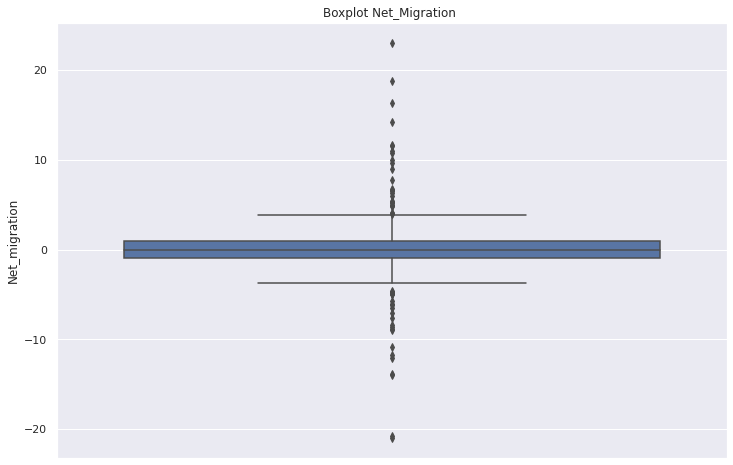

In [19]:
# Exibindo gráfico boxplot da variável 'Net_Migration'

sns.boxplot(df['Net_migration'], orient="vertical").set_title("Boxplot Net_Migration ");



In [20]:
def q5():
    # Retorne aqui o resultado da questão 4.
    # Obtendo o 1º e 3º quartil para variável 'Net_Migration'
    q1,q3 = df['Net_migration'].quantile([0.25,0.75])

    # Calculando o intervalo interquartil entre o 1º e 3º quartil
    iqr = q3 - q1

    # Calculando limite inferior e superior
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # Calculando quantidade de outliers para os grupos inferior e superior
    qtd_grupo_inferior = len(df.loc[df['Net_migration'] < limite_inferior])
    qtd_grupo_superior = len(df.loc[df['Net_migration'] > limite_superior])

    qtd = df['Net_migration'].size

    # Exibindo percentual de outliers para variável 'Net_Migration'
    print(f'Outliers: { ((qtd_grupo_inferior + qtd_grupo_superior) / qtd ) * 100 :.2f}%')

    return (qtd_grupo_inferior,qtd_grupo_superior,False)
q5()

Outliers: 22.03%


(24, 26, False)

In [21]:
# Carregando categorias e dataset
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)




In [33]:
def q6():
    # Retorne aqui o resultado da questão 6.
    # Instanciando o CountVectorizer
    vectorizer = CountVectorizer()

    # Realizando o fit e transform com os dados do corpus
    newsgroup_count = vectorizer.fit_transform(newsgroup.data)

    print(f'Documentos: \t {newsgroup_count.shape[0]}')
    print(f'Termos:  \t {newsgroup_count.shape[1]}')

    # Obtendo o índice do termo 'phone'
    phone_idx = vectorizer.vocabulary_[u'phone']

    # Contando a quantidade de vezes que o termo aparece
    qtd_phone = newsgroup_count[:,phone_idx].sum() 

    return int(qtd_phone)
q6()

Documentos: 	 1773
Termos:  	 27335


213

In [23]:
def q7():
    # Retorne aqui o resultado da questão 4.
    # Instanciando o TfidfVectorizer
    tfidf_vectorizer= TfidfVectorizer()

    # Realizando o fit e transform com os dados do corpus
    newsgroup_tfidf_vectorized = tfidf_vectorizer.fit_transform(newsgroup.data)

    # Obtendo o índice do termo 'phone'
    phone_idx = tfidf_vectorizer.vocabulary_.get(u"phone")

    # Obtendo o tf-idf do termo 'phone'
    tfidf_phone = round(newsgroup_tfidf_vectorized[:,phone_idx].sum(),3)

    return float(tfidf_phone)
q7()

8.888